In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import k_means
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, make_scorer, homogeneity_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib.backends import backend_pdf as bpdf
from scipy import stats
from sklearn.svm import SVC
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, LeaveOneOut
import pickle
from scipy.spatial.distance import *
from math import log10, floor
from community_simulator.visualization import StackPlot
from community_simulator.usertools import a_default,MakeMatrices,MakeParams,MakeInitialState,MakeConsumerDynamics,MakeResourceDynamics, BinaryRandomMatrix
from community_simulator import Community
from scipy.spatial.distance import pdist, squareform
from add_noise import *
from community_simulator.analysis import MakeFlux
colors = sns.color_palette()*20
markers = ['o','s','D','.']*20
%matplotlib inline

In [17]:
pd.__version__

'1.1.5'

# Simulations

In [22]:
a_current = {'sampling':'Binary', #{'Gaussian','Binary','Gamma'} specifies choice of sampling algorithm
          'SA': 100*np.ones(1), #Number of species in each specialist family (here, 3 families of 60 species)
          'MA': np.array([50,1]), #Number of resources in each class 
          'Sgen': 0, #Number of generalist species (unbiased sampling over alll resource classes)
          'muc': 10, #Mean sum of consumption rates (used in all models)
          'sigc': 5, #Standard deviation of sum of consumption rates for Gaussian and Gamma models
          'q': 0.0, #Preference strength of specialist families (0 for generalist and 1 for specialist)
          'c0':0.0, #Sum of background consumption rates in binary model
          'c1':1., #Specific consumption rate in binary model
          'l':0.0, #Leakage fraction
          'fs':0.9, #Fraction of secretion flux with same resource type
          'fw':0.05, #Fraction of secretion flux to 'waste' resource
          'sparsity':0.1, #Effective sparsity of metabolic matrix (between 0 and 1)
          'n_wells':1, #Number of independent wells
          'S':100, #Number of species per well (randomly sampled from the pool of size Stot = sum(SA) + Sgen)
          'food':0, #index of food source (when a single resource is supplied externally)
          'R0_food':100, #unperturbed fixed point for supplied food
          'regulation':'independent', #metabolic regulation (see dRdt)
          'symmetric':'on', # whether C=E
          'response':'type I', #functional response (see dRdt)
          'supply':'external' #resource supply (see dRdt)
         }

/Users/akshit/Library/CloudStorage/Dropbox-MIT/community-simulator-master/community_simulator/usertools.py:252: RuntimeWarning: divide by zero encountered in true_divide
  p = pd.Series(np.ones(M)*(1-assumptions['fs']-assumptions['fw'])/(M-MA-M_waste),index = DT.keys())


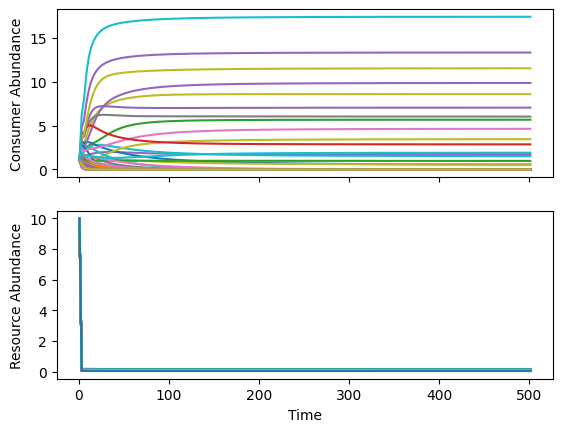

In [29]:
# S = 50
a = a_current.copy()
thresh = 1e-3
# a['l'] = 0.7
# a['MA'] = [50,1,1]
# a['SA'] = [40,5,5]
# a['Sgen'] = 0
# a['muc'] = 40
# M = np.sum(a['MA'])
# a['S'] = S
# a['food'] = 0
# a['R0_food'] = 200
# a['fw'] = 0.4
# a['fs'] = 0.4
# a['waste_type']=1
# a['sparsity'] = 0.1
# a['n_wells'] = 1
# a['q'] = 0.8
# a['supply'] = 'external'
# a['Stot'] = np.sum(a['SA'])
a['M'] = np.sum(a['MA'])
M = a['M']
S = a['S']

params = MakeParams(a)
init_state = MakeInitialState(a)
init_state[0]['W0'] = 1
params['R0'] = np.ones(M) * 2.0
init_state[1]['W0'] = 10.0

def dNdt(N,R,params):
    return MakeConsumerDynamics(a)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(a)(N,R,params)
dynamics = [dNdt,dRdt]

plate = Community(init_state,dynamics,params)
t,N,R = plate.TestWell(T=500,log_time=False,T0=1,ns=200)

In [37]:
N[-1,:]

array([ 3.83199474e-13, -4.91713808e-08,  4.50150290e-14, -2.27174603e-17,
        2.49820014e-11, -1.08517768e-17, -6.69165140e-16,  5.83776558e-14,
        8.60014851e+00, -6.54455828e-18, -2.52347380e-08, -1.40421520e-12,
       -6.31121847e-11, -1.39827333e-17,  9.81135134e-15, -1.66602465e-16,
        9.00759499e-14, -8.75982668e-16,  1.64318646e-12, -2.50120139e-10,
        2.47235144e-13, -6.24093416e-10,  5.67946560e+00,  1.14803305e-16,
        1.75665994e+00,  2.69916283e-17,  9.25578223e-17,  3.51847333e-13,
        1.69246776e-14,  1.53318063e+00,  5.61863589e-01,  4.77410270e-12,
        3.54710344e-11,  1.98213981e-16,  9.87632664e+00,  2.22143427e-12,
       -7.69836724e-19,  2.28911337e-14,  5.85897024e-01,  4.63065050e-15,
       -7.71162923e-14, -7.87791510e-18, -8.39163283e-16, -1.43432061e-15,
        4.53546471e-17,  6.48611039e-19,  7.56427282e-19,  1.77801442e-07,
        3.45592823e+00,  9.22685575e-05,  6.01519728e-11, -2.10064866e-18,
        9.77906407e-01, -

### Steady state

In [38]:
plate.SteadyState()

# CRM matrices

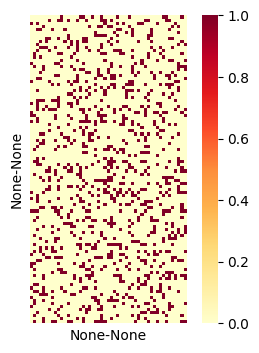

In [47]:
fig,ax=plt.subplots(figsize=(4,4))
sns.heatmap(params['c'],cmap='YlOrRd',vmin=0,square=True,xticklabels=False,yticklabels=False,cbar=True,ax=ax)
plt.show()

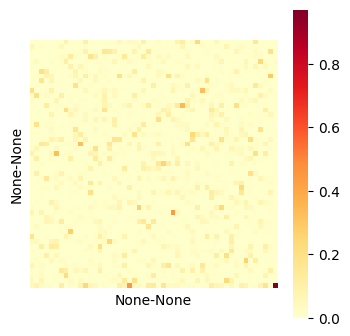

In [48]:
fig,ax=plt.subplots(figsize=(4,4))
sns.heatmap(params['D'],cmap='YlOrRd',vmin=0,square=True,xticklabels=False,yticklabels=False,cbar=True,ax=ax)
plt.show()

# Cooperative alpha matrix

In [49]:
def GiveAlphaK(a, params, plate, M):
    thresh = 1e-3
    alpha_master = pd.DataFrame(np.zeros((np.sum(a['SA'])+a['Sgen'],np.sum(a['SA'])+a['Sgen'])),index=plate.N.index,columns=plate.N.index)
    well = 'W0'
    Q = np.eye(M) - params['D']*params['l']
    A = np.eye(M) + Q*(params['c'].T.dot(plate.N[well].values))
    Ainv = pd.DataFrame(np.linalg.inv(A),index=A.index,columns=A.keys())
    alpha_full = (params['c']*(1-params['l'])).dot(Ainv).dot(Q).dot((params['c']*plate.R[well].values).T)
    alpha = alpha_full.loc[plate.N[well]>thresh]
    alpha = alpha.T.loc[plate.N[well]>thresh].T
    K_full = alpha_full.dot(plate.N[well])
    K = K_full.loc[plate.N[well]>thresh]
    cluster_full_true = alpha_full.index.levels[0][alpha_full.index.codes[0]]
    cluster_full_true = np.asarray([int(cluster_full_true[k][1]) for k in range(len(cluster_full_true))])
    cluster_true = alpha.index.levels[0][alpha.index.codes[0]]
    cluster_true = np.asarray([int(cluster_true[k][1]) for k in range(len(cluster_true))])

    return alpha, K, cluster_true

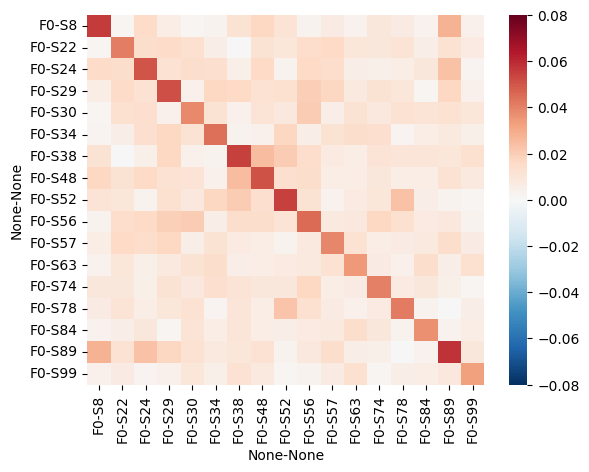

In [50]:
alpha, K, cluster_true = GiveAlphaK(a, params, plate, M)

fig,ax = plt.subplots()
#sns.heatmap((alpha.T/np.diag(alpha)).T,cmap='RdBu_r',vmin=-1,vmax=1,ax=ax)
sns.heatmap((alpha.T/K).T,cmap='RdBu_r',ax=ax,vmin=-.08,vmax=.08)
pdf = bpdf.PdfPages('comp_coop_figs/alpha_cooperative.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Competitive alpha matrix for linear resource model

In [44]:
from scipy.integrate import odeint

In [45]:
def comptt_model_dynamics(curr_state, t, params, K_supply):
    N = curr_state[:S]
    R = curr_state[S:]
    C = params['c']
    m = params['m']

    # Species growth term
    growth_term = (C @ R) - m
    
    # Resource consumption and production term
    consumption_term = N @ (C * R)

    # Differential equations
    dN = N * params['g'] * (growth_term)
    dR = K_supply - params['w'] * R - consumption_term

    return np.concatenate([dN, dR])

In [46]:
t = np.linspace(0, 200, 1000)
K_supply = 2.0 * np.ones(M)
K_supply[-1] = 0.0
init_conds = np.concatenate([init_state[0], init_state[1]]).flatten()
solution = odeint(comptt_model_dynamics, init_conds, t, args=(params, K_supply))

In [47]:
Nf = solution[-1,:S]
Rf = solution[-1,S:]

$$A_{ij} =[CQ^{-1}E]_{ij} = \sum_{\alpha} {g_i \mathrm{w}_{i \alpha} c_{i \alpha} c_{j \alpha} R^*_\alpha \over \omega_\alpha^{eff}}$$

where

$$ \omega_\alpha ^{eff}= \omega + f_\alpha $$

and 

$$ f_\alpha=\sum_i c_{i \alpha}N_i^\ast

In [48]:
def GiveAlphaK_Comptt(a, params, plate, M):
    thresh = 1e-2
    alpha_master = pd.DataFrame(np.zeros((np.sum(a['SA'])+a['Sgen'],np.sum(a['SA'])+a['Sgen'])),index=plate.N.index,columns=plate.N.index)
    f_alpha = (params['c'].T).dot(Nf)
    w_eff_alpha = params['w'] + f_alpha
    alpha_full = (params['c'] * ((Rf/w_eff_alpha))).dot(params['c'].T)
    alpha = alpha_full.loc[Nf>thresh]
    alpha = alpha.T.loc[Nf>thresh].T
    K_full = alpha_full.dot(Nf)
    K = K_full.loc[Nf>thresh]
    cluster_full_true = alpha_full.index.levels[0][alpha_full.index.codes[0]]
    cluster_full_true = np.asarray([int(cluster_full_true[k][1]) for k in range(len(cluster_full_true))])
    cluster_true = alpha.index.levels[0][alpha.index.codes[0]]
    cluster_true = np.asarray([int(cluster_true[k][1]) for k in range(len(cluster_true))])

    return alpha, K, cluster_true

In [49]:
alpha_comp, K_comp, cluster_full_true = GiveAlphaK_Comptt(a, params, plate, M)

In [50]:
alpha_comp.mean()

F0  S4     0.012987
    S9     0.011499
    S14    0.012396
    S22    0.009998
    S27    0.008208
    S33    0.009257
    S41    0.013736
    S46    0.010695
    S47    0.010727
    S55    0.013877
    S59    0.009177
    S64    0.011206
    S75    0.012416
    S78    0.009542
    S84    0.009264
    S85    0.009633
    S87    0.010498
    S95    0.012534
dtype: float64

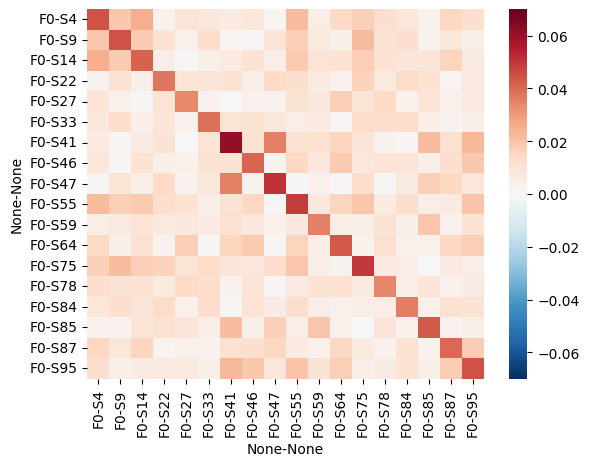

In [54]:
fig,ax = plt.subplots()
#sns.heatmap((alpha.T/np.diag(alpha)).T,cmap='RdBu_r',vmin=-1,vmax=1,ax=ax)
sns.heatmap((alpha_comp.T).T,cmap='RdBu_r',ax=ax,vmin=-.07,vmax=.07)
pdf = bpdf.PdfPages('comp_coop_figs/alpha_competitive.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()